In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [15]:
dir_ = Path('convert')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,convert/violence/violence_52.jpg,violence
1,convert/happiness/happiness_12.jpg,happiness
2,convert/depression/depression_110.jpg,depression
3,convert/depression/depression_137.jpg,depression
4,convert/violence/violence_44.jpg,violence


In [16]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 361

Number of different labels: 3

Labels: ['violence' 'happiness' 'depression']


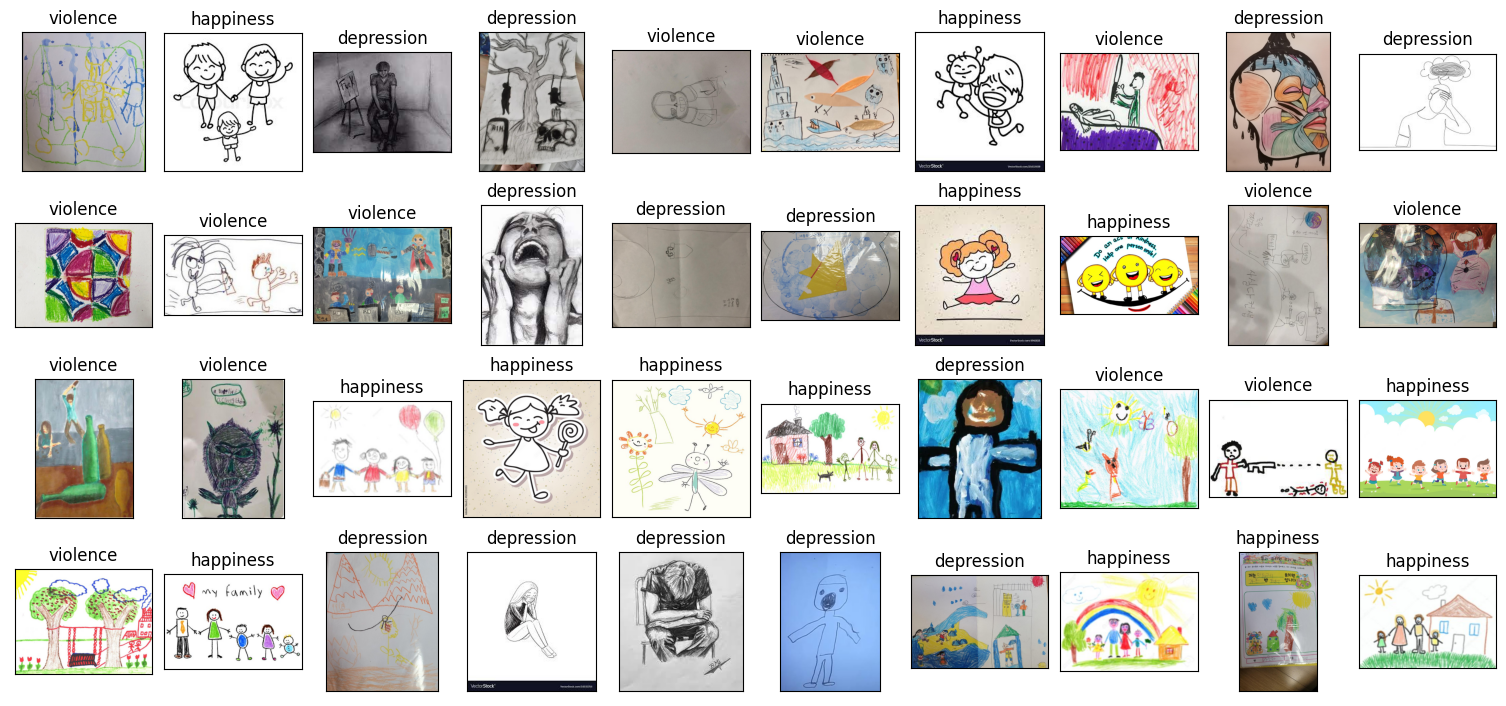

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

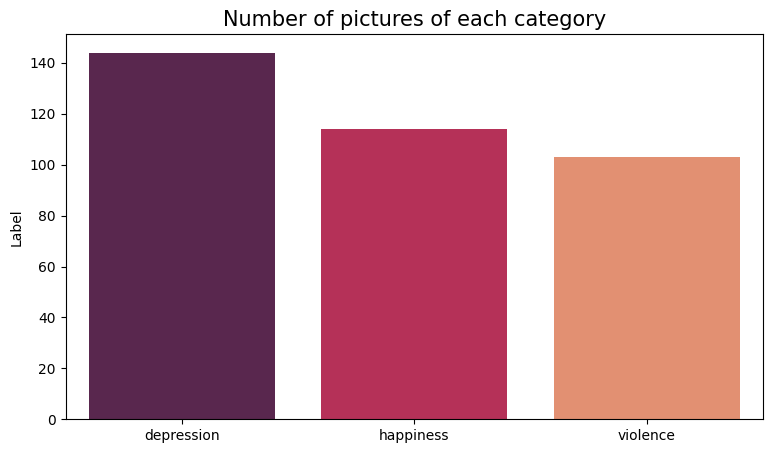

In [18]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [19]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((324, 2), (37, 2))

In [21]:
images_dir = 'convert'
images_dir

'convert'

In [24]:
emotion_dirs = os.listdir(images_dir)
emotion_dirs = ['depression', 'violence', 'happiness']

In [26]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
train_input_shape = (224, 224, 3)
n_classes = 3

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory(directory=images_dir, classes=emotion_dirs,
                                                 target_size = train_input_shape[0:2],
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory(directory=images_dir, classes=emotion_dirs,
                                                 target_size = train_input_shape[0:2],
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',subset='validation')

Found 291 images belonging to 3 classes.
Found 70 images belonging to 3 classes.


In [135]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler


input_tensor = Input(shape=train_input_shape)

#x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

# cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(3, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_416 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_407 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                               
                                                                 
 activation_391 (Activation)  (None, 224, 224, 32)     0         
                                                                 
 conv2d_417 (Conv2D)         (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_408 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                        

In [132]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=train_input_shape))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=3, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_413 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 111, 111, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_414 (Conv2D)         (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_104 (MaxPooli  (None, 54, 54, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 93312)             0         
                                                                 
 dense_193 (Dense)           (None, 128)              

In [32]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
10/10 [==============================] - 9s 721ms/step - loss: 4.6772 - accuracy: 0.3368 - val_loss: 1.1094 - val_accuracy: 0.2714
Epoch 2/10
10/10 [==============================] - 6s 541ms/step - loss: 1.0781 - accuracy: 0.3952 - val_loss: 1.0901 - val_accuracy: 0.3714
Epoch 3/10
10/10 [==============================] - 6s 561ms/step - loss: 1.0470 - accuracy: 0.4880 - val_loss: 1.1225 - val_accuracy: 0.4286
Epoch 4/10
10/10 [==============================] - 6s 572ms/step - loss: 0.9157 - accuracy: 0.6632 - val_loss: 1.1267 - val_accuracy: 0.3571
Epoch 5/10
10/10 [==============================] - 6s 547ms/step - loss: 0.7497 - accuracy: 0.7251 - val_loss: 1.2104 - val_accuracy: 0.3571
Epoch 6/10
10/10 [==============================] - 7s 719ms/step - loss: 0.4999 - accuracy: 0.8144 - val_loss: 1.1460 - val_accuracy: 0.4571
Epoch 7/10
10/10 [==============================] - 7s 636ms/step - loss: 0.2857 - accuracy: 0.9175 - val_loss: 1.5734 - val_accuracy: 0.4714
Epoch 

In [33]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [50]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetV2L": {"model":tf.keras.applications.EfficientNetV2L, "perf":0},
    "EfficientNetV2S": {"model":tf.keras.applications.EfficientNetV2S, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Found 292 validated image filenames belonging to 3 classes.
Found 32 validated image filenames belonging to 3 classes.
Found 37 validated image filenames belonging to 3 classes.




In [51]:
# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

DenseNet121          trained in 15.08 sec
51877672/51877672 [==============================] - 1s 0us/step
DenseNet169          trained in 23.91 sec
MobileNetV2          trained in 13.68 sec
DenseNet201          trained in 28.99 sec
EfficientNetB0       trained in 12.53 sec
EfficientNetB1       trained in 22.3 sec
473176280/473176280 [==============================] - 52s 0us/step
EfficientNetV2L      trained in 65.77 sec
EfficientNetV2S      trained in 31.23 sec
InceptionV3          trained in 9.66 sec
219055592/219055592 [==============================] - 4s 0us/step
InceptionResNetV2    trained in 23.65 sec
MobileNetV3Large     trained in 10.86 sec
ResNet152V2          trained in 28.25 sec
ResNet50             trained in 12.85 sec
ResNet50V2           trained in 11.94 sec
VGG19                trained in 19.03 sec
VGG16                trained in 14.47 sec
Xception             trained in 12.11 sec


In [52]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

2/2 [==============================] - 3s 345ms/step
**DenseNet121 has a 48.65% accuracy on the test set**
2/2 [==============================] - 7s 282ms/step
**DenseNet169 has a 62.16% accuracy on the test set**
2/2 [==============================] - 1s 52ms/step
**MobileNetV2 has a 62.16% accuracy on the test set**
2/2 [==============================] - 5s 393ms/step
**DenseNet201 has a 62.16% accuracy on the test set**
2/2 [==============================] - 2s 105ms/step
**EfficientNetB0 has a 35.14% accuracy on the test set**
2/2 [==============================] - 3s 135ms/step
**EfficientNetB1 has a 43.24% accuracy on the test set**
2/2 [==============================] - 10s 674ms/step
**EfficientNetV2L has a 40.54% accuracy on the test set**
2/2 [==============================] - 4s 200ms/step
**EfficientNetV2S has a 37.84% accuracy on the test set**
2/2 [==============================] - 2s 97ms/step
**InceptionV3 has a 40.54% accuracy on the test set**
2/2 [===================

,model,val_accuracy,accuracy,Training time (sec)
0,Xception,0.6562,0.6216,12.11
1,MobileNetV2,0.6875,0.6216,13.68
2,DenseNet201,0.7188,0.6216,28.99
3,DenseNet169,0.6562,0.6216,23.91
4,ResNet152V2,0.6875,0.5946,28.25
5,ResNet50V2,0.6875,0.5405,11.94
6,MobileNetV3Large,0.5000,0.5405,10.86
7,InceptionResNetV2,0.5312,0.5135,23.65
8,VGG16,0.6250,0.4865,14.47
9,DenseNet121,0.5938,0.4865,15.08


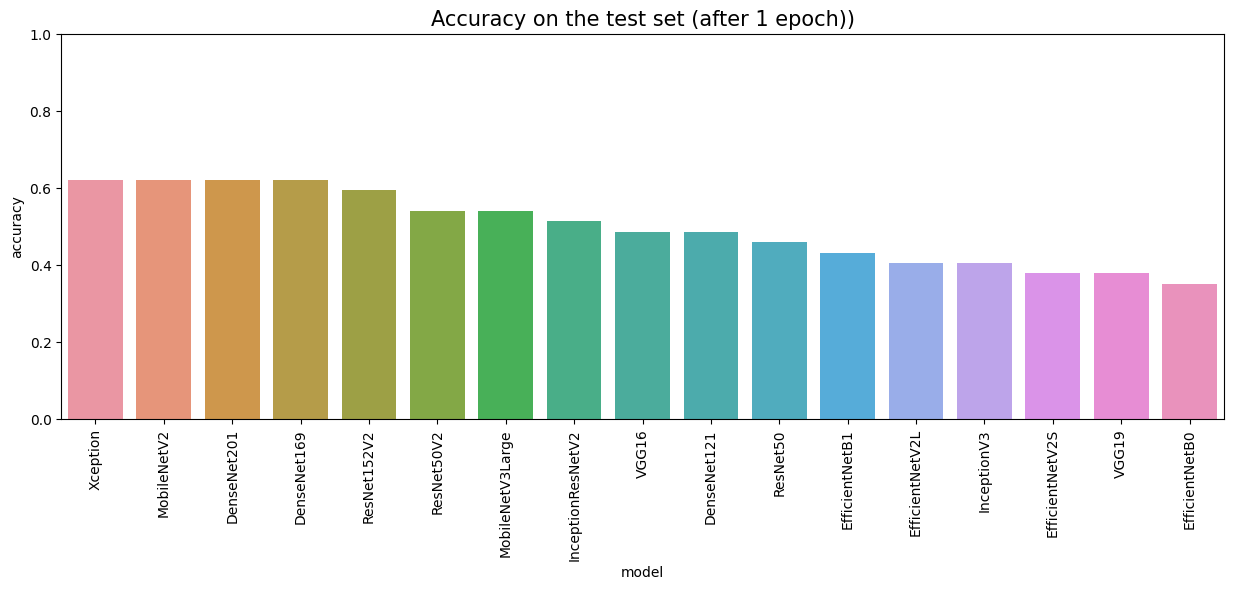

In [53]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

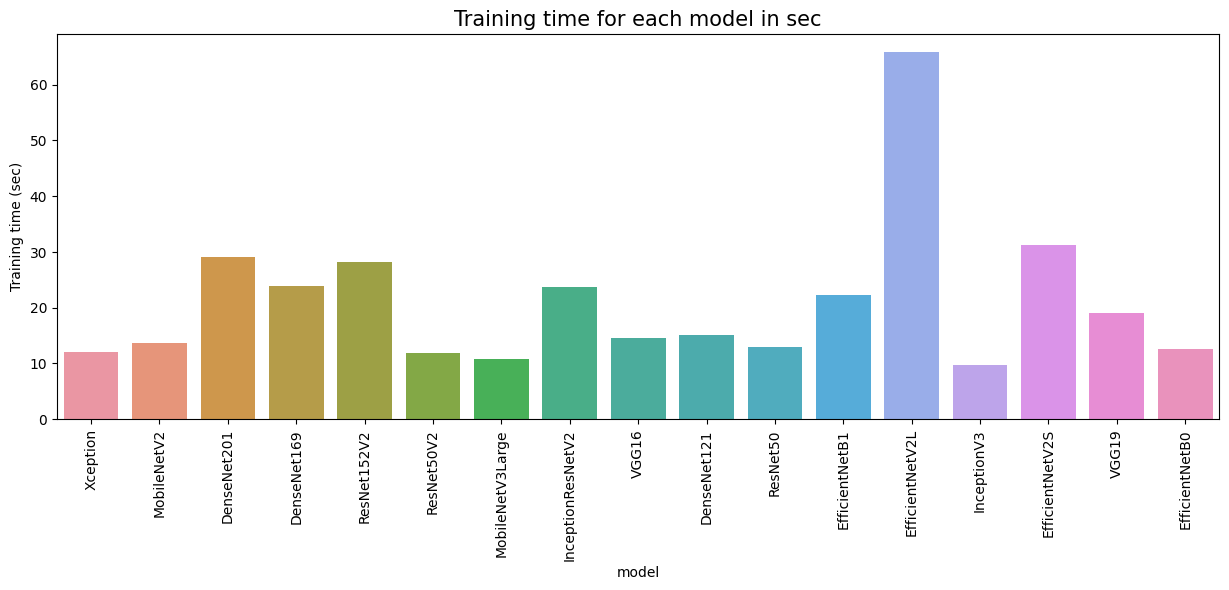

In [54]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [127]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet152V2)
history = model.fit(train_images,validation_data=val_images,epochs=10)

Found 292 validated image filenames belonging to 3 classes.
Found 32 validated image filenames belonging to 3 classes.
Found 37 validated image filenames belonging to 3 classes.
Epoch 1/10
10/10 [==============================] - 27s 2s/step - loss: 0.9721 - accuracy: 0.5411 - val_loss: 0.8061 - val_accuracy: 0.6562
Epoch 2/10
10/10 [==============================] - 15s 1s/step - loss: 0.5711 - accuracy: 0.7603 - val_loss: 0.7580 - val_accuracy: 0.6562
Epoch 3/10
10/10 [==============================] - 16s 2s/step - loss: 0.3040 - accuracy: 0.9144 - val_loss: 0.5546 - val_accuracy: 0.7500
Epoch 4/10
10/10 [==============================] - 17s 2s/step - loss: 0.1868 - accuracy: 0.9486 - val_loss: 0.5732 - val_accuracy: 0.7188
Epoch 5/10
10/10 [==============================] - 17s 2s/step - loss: 0.0995 - accuracy: 0.9966 - val_loss: 0.5796 - val_accuracy: 0.7812
Epoch 6/10
10/10 [==============================] - 17s 2s/step - loss: 0.0573 - accuracy: 0.9966 - val_loss: 0.6566 - val

In [105]:
model.save('ResNet152V2(v2_76).h5')

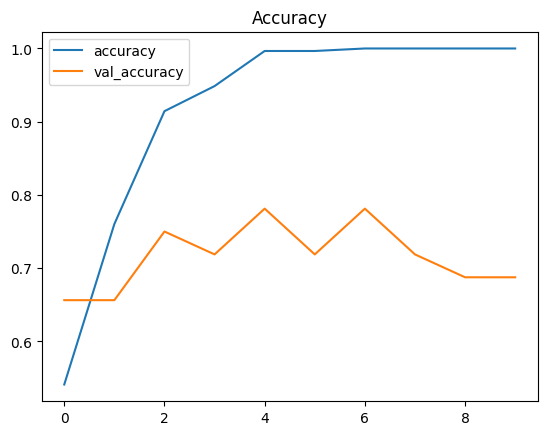

In [128]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [129]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

2/2 [==============================] - 6s 459ms/step
Accuracy on the test set: 75.68%


In [43]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet121)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 292 validated image filenames belonging to 3 classes.
Found 32 validated image filenames belonging to 3 classes.
Found 37 validated image filenames belonging to 3 classes.
Epoch 1/7
10/10 [==============================] - 17s 1s/step - loss: 1.0527 - accuracy: 0.4692 - val_loss: 0.8644 - val_accuracy: 0.5312
Epoch 2/7
10/10 [==============================] - 9s 911ms/step - loss: 0.7179 - accuracy: 0.6644 - val_loss: 0.7045 - val_accuracy: 0.6875
Epoch 3/7
10/10 [==============================] - 13s 1s/step - loss: 0.5577 - accuracy: 0.7397 - val_loss: 0.6348 - val_accuracy: 0.6250
Epoch 4/7
10/10 [==============================] - 9s 893ms/step - loss: 0.4308 - accuracy: 0.8356 - val_loss: 0.6024 - val_accuracy: 0.7188
Epoch 5/7
10/10 [==============================] - 9s 895ms/step - loss: 0.3774 - accuracy: 0.8493 - val_loss: 0.5318 - val_accuracy: 0.7500
Epoch 6/7
10/10 [==============================] - 10s 950ms/step - loss: 0.3257 - accuracy: 0.8664 - val_loss: 0.5392 - 

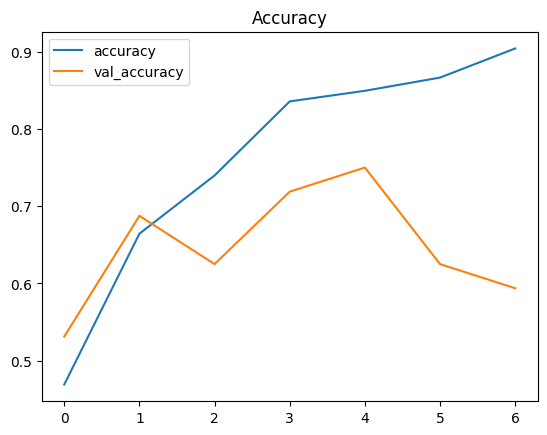

In [44]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [67]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

2/2 [==============================] - 5s 427ms/step
Accuracy on the test set: 72.97%


In [4]:
from PIL import Image

In [5]:
file_path = 'test_img'
file_path

'test_img'

In [6]:
file_names = os.listdir(file_path)
file_names

['depression', 'violence', 'happiness']

In [8]:
image_names = os.listdir(file_path + f'/{file_names[0]}')
image_names

['depression_131.jfif',
 'depression_92.png',
 'depression_113.jfif',
 'depression_148.png',
 'depression_145.jfif',
 'depression_58.jpg',
 'depression_130.jfif',
 'depression_121.jfif',
 'depression_8.jpg',
 'depression_106.jfif',
 'depression_82.jpg',
 'depression_19.jpg',
 'depression_27.jpg',
 'depression_32.jpg',
 'depression_134.jfif',
 'depression_6.jpg',
 'depression_43.jpg',
 'depression_17.jpg',
 'depression_21.jpg',
 'depression_68.jpg',
 'depression_123.jfif',
 'depression_138.jfif',
 'depression_81.jpg',
 'depression_132.jfif',
 'depression_28.jpg',
 'depression_136.jfif',
 'depression_139.jfif',
 'depression_150.jfif',
 'depression_127.jfif',
 'depression_7.jpg',
 'depression_100.jpg',
 'depression_85.PNG',
 'depression_80.jpg',
 'depression_90.png',
 'depression_120.jfif',
 'depression_122.jfif',
 'depression_11.jpg',
 'depression_89.png',
 'depression_34.jpg',
 'depression_4.jpg',
 'depression_101.jpg',
 'depression_73.jpg',
 'depression_126.jfif',
 'depression_99.jpg',

In [12]:
for i in range(3):
    image_names = os.listdir(file_path + f'/{file_names[i]}')
    for j in range(len(image_names)):
        im = Image.open(file_path + f'/{file_names[i]}/{image_names[j]}').convert('RGB')
        im.save('convert' + f'/{file_names[i]}/{file_names[i]}_{j}.jpg', 'jpeg')